The goal is to train a parametric circuit to fit the **Up-Quark's Parton Distribution Fucntion**.

What is Parton Distribution Function (PDF) ?

PDFs are probability distribution functions that describe the probability of finding a parton (quark, antiquark, or gluon) carrying a fraction x of the proton's momentum at a given energy scale Q^2.
- PDFs provide insights into the internal structure of protons, revealing how quarks and gluons are distributed within.
- PDFs are essential for predicting the outcomes of high energy particle collisions as those in LHC.

Energy Scale (Q^2) determines the resolution at which the proton's structure is probed.

In [58]:
pip install qibo

In [2]:
pip install qibojit

In [3]:
pip install git+https://github.com/qiboteam/qiboedu

  Cloning https://github.com/qiboteam/qiboedu to /tmp/pip-req-build-34u80tmw
  Running command git clone --filter=blob:none --quiet https://github.com/qiboteam/qiboedu /tmp/pip-req-build-34u80tmw
  Resolved https://github.com/qiboteam/qiboedu to commit c05f53215f1e0efff377a0310748b8dc3753dac7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for qiboedu: filename=qiboedu-0.1.0-py3-none-any.whl size=17156 sha256=56c137a9dd27f211d0a91abcecfba4ce11b706575eda0660b3324fdf093cf208
  Stored in directory: /tmp/pip-ephem-wheel-cache-s8m15zin/wheels/88/3e/b3/56312e57970f2fabccd0b51c358665866db085f22720ced56a
Successfully built qiboedu


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import qibo
from qibo import Circuit, gates, hamiltonians

In [5]:
from qibo.optimizers import optimize

In [6]:
qibo.list_available_backends()

{'numpy': True, 'pytorch': True, 'qulacs': False}

In [63]:
from sys import platform
qibo.set_backend('qibojit')

[Qibo 0.2.13|INFO|2024-11-07 06:08:43]: Using qibojit (numba) backend on /CPU:0
INFO:qibo.config:Using qibojit (numba) backend on /CPU:0


In [7]:
dt = np.loadtxt("/content/datau.dat")
x_lables = dt[:, 0]
y_lables = dt[:, 1]
indices = np.arange(0, len(y_lables), 4)
selected_features = x_lables[indices]
selected_labels = y_lables[indices]

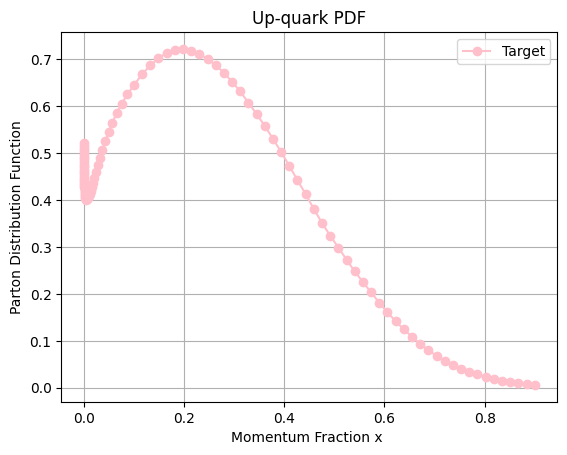

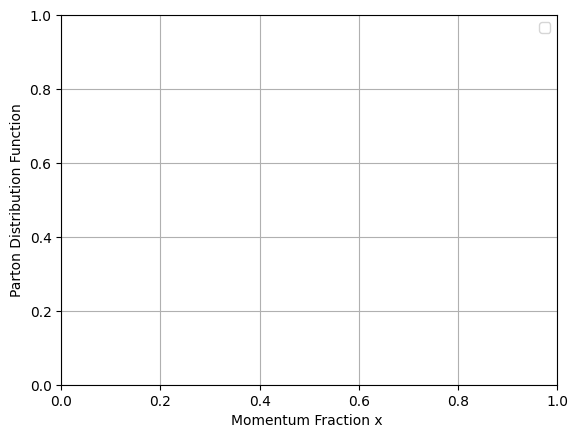

In [93]:
def plot_uquark(x, y,predictions=None):
    plt.plot(x_lables, y_lables, label="Target",marker='o', linestyle='-',color='pink')
    plt.xlabel("Momentum Fraction x ")
    plt.ylabel("Parton Distribution Function")
    plt.title("Up-quark PDF")
    plt.legend()
    plt.grid(True)
    plt.show()
    if predictions is not None:
        plt.plot(x, predictions, color="purple", ls="-", lw=1.5, label="Predictions", marker=".", markersize=10, alpha=0.7)
    plt.grid(True)
    plt.xlabel("Momentum Fraction x ")
    plt.ylabel("Parton Distribution Function")
    plt.legend()
    plt.show()

plot_uquark(x_lables, y_lables)

In [69]:
def set_parameters(circuit, nlayers, parameters, x):
    """
    Upload data and trainable parameters into a circuit.
    We want to combine data and params so that angle = p1 * x + p2
    """
    params = []
    index = 0
    for _ in range(nlayers):
        params.append(parameters[index] * x + parameters[index + 1])
        params.append(parameters[index + 2] * np.log(x) + parameters[index + 3])
        index += 4
    circuit.set_parameters(params)
    return circuit

In [86]:
def predict(parameters, dt, nlayers, circuit, hamiltonian):
    """Compute predictions given dataset and parameters."""
    predictions = []
    for x in dt:
        circuit = set_parameters(circuit, nlayers, parameters, x)
        predictions.append(hamiltonian.expectation(circuit().state()))
    return predictions

In [71]:
def loss_function(parameters, dt, labels, circuit, nlayers, hamiltonian):
    """Compute loss function considering all data and a given set of parameters."""
    loss = 0
    predictions = predict(parameters, dt, nlayers, circuit, hamiltonian)
    for i, pred in enumerate(predictions):
        loss += (pred - labels[i])**2
    return loss / len(labels)

In [84]:
def build_parametric_circuit(nlayers):
    c = Circuit(1)
    for _ in range(nlayers):
        c.add(gates.RY(q=0, theta=0.))
        c.add(gates.RZ(q=0, theta=0.))
    c.add(gates.M(0))
    return c

In [85]:
# defining the parametric quantum circuit
nlayers = 4
pqc = build_parametric_circuit(nlayers)

np.random.seed(42)
initial_parameters = np.random.randn(nlayers * 4)
pqc = set_parameters(pqc, nlayers, initial_parameters, 0.3)

# defining the observable
h = hamiltonians.Z(1)

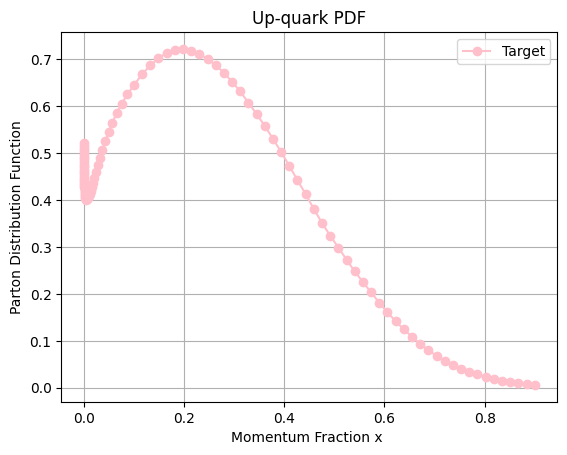

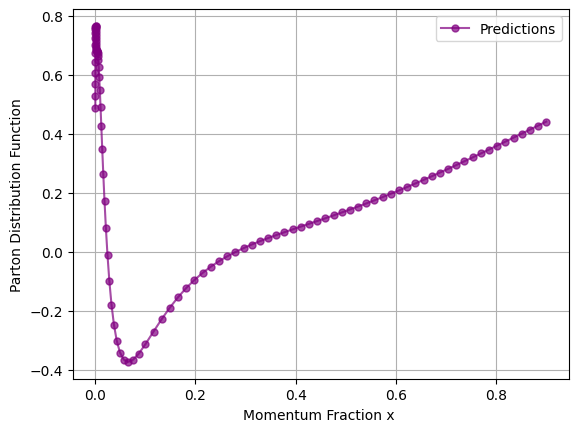

In [90]:
predictions = predict(initial_parameters, x_lables, nlayers, pqc, h)
plot_uquark(x_lables, y_lables, predictions)

In [81]:
optimization_result = optimize(loss_function, initial_parameters=initial_parameters, method="cma", args=(x_lables, y_lables, pqc, nlayers, h), options={"maxiter": 2000})

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=1054020, Thu Nov  7 06:22:53 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.180481886468645e-01 1.0e+00 1.54e+00  1e+00  2e+00 0:01.0
    2     24 1.412171420011765e-01 1.1e+00 1.53e+00  1e+00  2e+00 0:01.9
    3     36 2.496570146422770e-01 1.2e+00 1.51e+00  1e+00  2e+00 0:02.7
    8     96 3.245763558545575e-01 1.4e+00 1.60e+00  2e+00  2e+00 0:06.1
   15    180 3.408433574389013e-01 1.6e+00 1.89e+00  2e+00  2e+00 0:10.2
   23    276 3.977485693897891e-01 2.0e+00 1.94e+00  2e+00  2e+00 0:15.7
   32    384 2.451333997068035e-01 2.1e+00 1.60e+00  1e+00  2e+00 0:21.8
   44    528 1.459960830502872e-01 2.3e+00 1.38e+00  1e+00  1e+00 0:29.5
   57    684 1.443175021097664e-01 2.6e+00 1.66e+00  1e+00  2e+00 0:38.0
   70    840 3.941676523940591e-01 2.9e+00 1.78e+00  2e+00  2e+00 0:47.3
   87   1044 2.640529220890515e-01 2.9e+00 1.62e+00  1e+00  2e+00 0:58.2
  100   1200 2.251216792715783e-

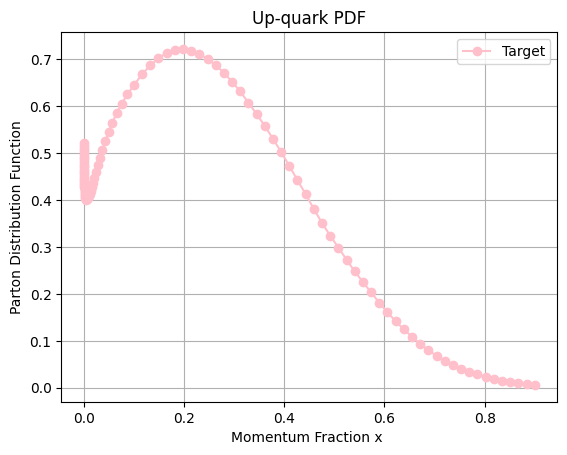

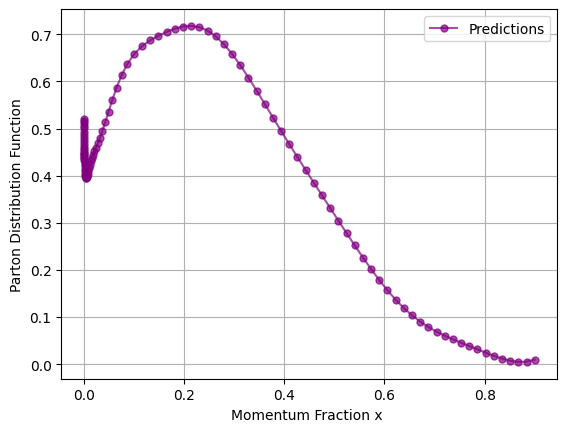

In [91]:
params = optimization_result[1]
predictions = predict(params, x_lables, nlayers, pqc, h)
plot_uquark(x_lables,y_lables, predictions)

Once the circuit has been trained successfully, this model can be used for a number of applictaions in HEP:

- Used in Monto Carlo Simulations to generate more accurate predictions for particle collisions at High Energy Physics experiements.
- Up-Quark PDF helps us get an understanding of proton's internal structure.

The fitted PDF can be used to test the predictions of the standard model with higher precision.